In [1]:
import warnings
from typing import List, Any
import random
import keras
import matplotlib.pyplot as plt  # for plotting
import os  # provides a way of using operating system dependent functionality
import cv2  # Image handling library
import numpy as np
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout   # Import of keras model and hidden layers for our convolutional network

warnings.filterwarnings('ignore')


# Data Processing & Creation

In [2]:

CATEGORIES = ["01_palm", '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved',
                  '09_c',
                  '10_down']
IMG_SIZE = 120

In [3]:

# paths for dataset
data_path = "leapGestRecog"


def data_preprocessing(file_path):
    # Loading the images and their class(0 - 9)
    image_data = []
    for dr in os.listdir(file_path):
        for category in CATEGORIES:
            class_index = CATEGORIES.index(category)
            path = os.path.join(file_path, dr, category)
            for img in os.listdir(path):
                try:
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
                except Exception as e:
                    pass
    return image_data


In [4]:
images = []
images = data_preprocessing(data_path)

In [5]:
random.shuffle(images)

In [6]:
input_data = []
label = []
for x, y in images:
    input_data.append(x)
    label.append(y)

In [7]:
print(label[:9])

[4, 1, 1, 9, 0, 2, 4, 4, 5]


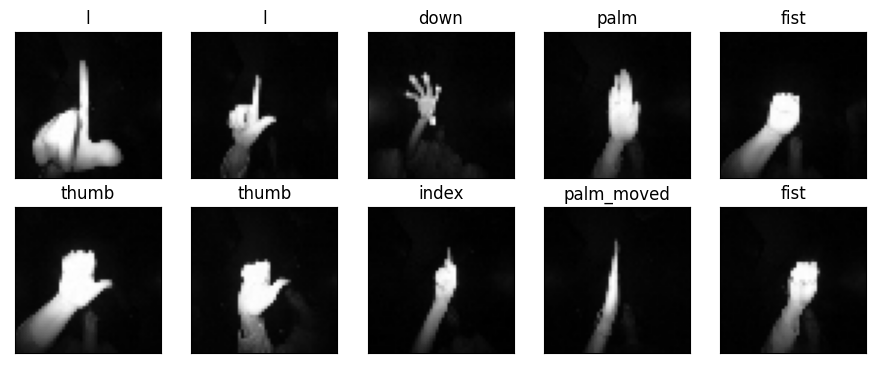

In [8]:
plt.figure(1, figsize=(11,11))
for i in range(1,11):
    plt.subplot(5,5,i)
    plt.imshow(images[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [9]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [10]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')

In [11]:
label[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int8)

In [12]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [13]:
# splitting the input_data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.25, random_state=0)

# Model

In [14]:
from keras.models import Sequential

In [15]:
def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [16]:
model = create_model((IMG_SIZE,IMG_SIZE,1))

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
file_s = 'Hand_Gesture.h5'
checkpoint = ModelCheckpoint(file_s, monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 'epoch')
Early_stop = EarlyStopping(patience = 75, monitor = 'val_loss',restore_best_weights = 'True')
callback_list = [checkpoint, Early_stop]

In [18]:
model.fit(X_train, y_train, epochs = 11, batch_size=64, validation_data=(X_test, y_test), callbacks = callback_list)

Epoch 1/11


235/235 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8634
Epoch 1: val_loss improved from inf to 0.00778, saving model to Hand_Gesture.h5
235/235 [==============================] - 32s 130ms/step - loss: 0.4124 - accuracy: 0.8634 - val_loss: 0.0078 - val_accuracy: 0.9982
Epoch 2/11
234/235 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9953
Epoch 2: val_loss did not improve from 0.00778
235/235 [==============================] - 29s 124ms/step - loss: 0.0157 - accuracy: 0.9953 - val_loss: 0.0130 - val_accuracy: 0.9940
Epoch 3/11
235/235 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9988
Epoch 3: val_loss improved from 0.00778 to 0.00458, saving model to Hand_Gesture.h5
235/235 [==============================] - 30s 127ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0046 - val_accuracy: 0.9974
Epoch 4/11
235/235 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993
E

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                        

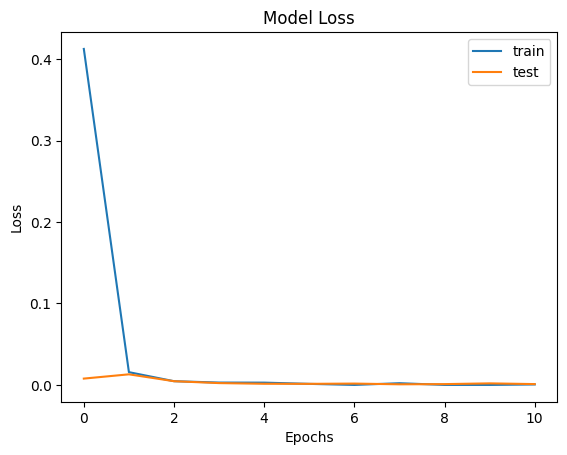

In [20]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

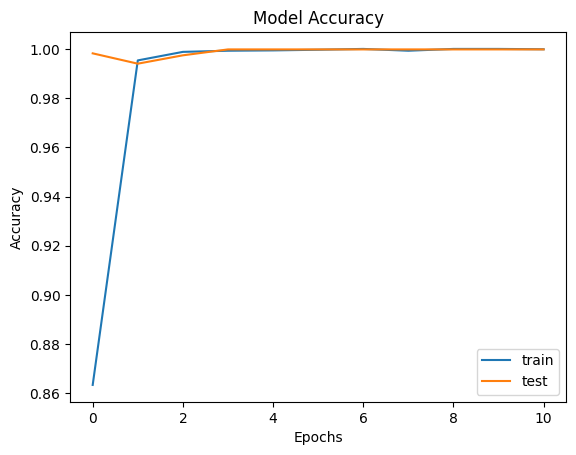

In [21]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

157/157 [==============================] - 2s 14ms/step - loss: 0.0010 - accuracy: 0.9998
Test accuracy: 99.98%
